## Imports & Helpers

In [6]:
from gnpy.core.utils import load_json
from convert import convert_file
from gnpy.core.equipment import *
from argparse import ArgumentParser
from sys import exit
from pathlib import Path
from logging import getLogger, basicConfig, INFO, ERROR, DEBUG

from matplotlib.pyplot import show, axis, figure, title
from networkx import (draw_networkx_nodes, draw_networkx_edges,
                      draw_networkx_labels, dijkstra_path)

from gnpy.core import network_from_json, build_network
from gnpy.core.elements import Transceiver, Fiber, Edfa
from gnpy.core.info import SpectralInformation, Channel, Power
from os import getcwd

In [8]:
logger = getLogger(__package__ or __name__)
eqpt_library = {}
EQPT_LIBRARY_FILENAME = Path(getcwd()) / 'eqpt_config.json'

In [9]:
def format_si(spectral_infos):
    return '\n'.join([
        f'#{idx} Carrier(frequency={c.frequency},\n  power=Power(signal={c.power.signal}, nli={c.power.nli}, ase={c.power.ase}))'
        for idx, si in sorted(set(spectral_infos))
        for c in set(si.carriers)
    ])

In [10]:
def plot_network_graph(network, path, source, sink):
    nodelist = [n for n in network.nodes() if isinstance(n, (Transceiver, Fiber))]
    pathnodes = [n for n in path if isinstance(n, (Transceiver, Fiber))]
    edgelist = [(u, v) for u, v in zip(pathnodes, pathnodes[1:])]
    node_color = ['#ff0000' if n is source or n is sink else
                  '#900000' if n in path else '#ffdfdf'
                  for n in nodelist]
    edge_color = ['#ff9090' if u in path and v in path else '#ababab'
                  for u, v in edgelist]
    labels = {n: n.location.city if isinstance(n, Transceiver) else ''
              for n in pathnodes}

    fig = figure()
    pos = {n: (n.lng, n.lat) for n in nodelist}
    kwargs = {'figure': fig, 'pos': pos}
    plot = draw_networkx_nodes(network, nodelist=nodelist, node_color=node_color, **kwargs)
    draw_networkx_edges(network, edgelist=edgelist, edge_color=edge_color, **kwargs)
    draw_networkx_labels(network, labels=labels, font_size=14, **kwargs)
    title(f'Propagating from {source.loc.city} to {sink.loc.city}')
    axis('off')
    show()

# Main Example

In [13]:
NETWORK = 'edfa_example_network.json'
SOURCE = ''
SINK = ''

invalid souce node specified: '', replaced with Transceiver Site_A
invalid destination node specified: '', replaced with Transceiver Site_B
There are 4 network elements between Transceiver Site_A and Transceiver Site_B
Transceiver Site_A
Fiber Span1
  length (m): 80000.00
  loss (dB):  16.00
Edfa Edfa1
  type_variety:      std_low_gain
  gain (dB):         16.00
  noise figure (dB): 7.12
  Power In (dBm):    3.83
  Power Out (dBm):   19.83
Transceiver Site_B
  OSNR ASE (1nm):        34.83
  OSNR ASE (signal bw):  30.75
  SNR total (signal bw): 27.36


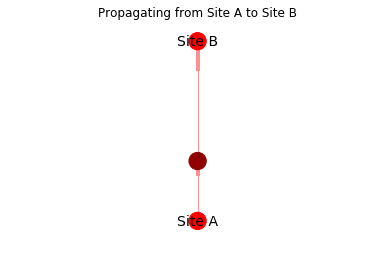

In [15]:
input_filename = NETWORK
split_filename = input_filename.split(".")
json_filename = split_filename[0]+'.json'
try:
    assert split_filename[1] in ('json','xls','csv','xlsm')
except AssertionError as e:
    print(f'invalid file extension .{split_filename[1]}')
    raise e
if split_filename[1] != 'json':
    print(f'parse excel input to {json_filename}')
    convert_file(input_filename)

json_data = load_json(json_filename)
read_eqpt_library(EQPT_LIBRARY_FILENAME)

network = network_from_json(json_data)
build_network(network)

spacing = 0.05 #THz
si = SpectralInformation() # !! SI units W, Hz
si = si.update(carriers=tuple(Channel(f, (191.3+spacing*f)*1e12, 
        32e9, 0.15, Power(1e-3, 0, 0)) for f in range(1,97)))

trx = [n for n in network.nodes() if isinstance(n, Transceiver)]
    
try:
    source = next(el for el in trx if el.uid == SOURCE)
except StopIteration as e:
    source = trx[0]
    print(f'invalid souce node specified: {SOURCE!r}, replaced with {source}')

try:
    sink = next(el for el in trx if el.uid == SINK)
except StopIteration as e:
    sink = trx[1]
    print(f'invalid destination node specified: {SINK!r}, replaced with {sink}')

path = dijkstra_path(network, source, sink)
print(f'There are {len(path)} network elements between {source} and {sink}')

for el in path:
    si = el(si)
    print(el)

plot_network_graph(network, path, source, sink)